## Reference:　https://www.kaggle.com/uysimty/keras-cnn-dog-or-cat-classification

In [40]:
import numpy as np
import pandas as pd 
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os
print(os.listdir("./dataset256x256/dataset_256x256/"))

['test', 'train']


In [41]:
FAST_RUN = False
IMAGE_WIDTH=256
IMAGE_HEIGHT=256
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

In [42]:
# cat == 0, LeopardCat ==1

filenames = os.listdir("./dataset256x256/dataset_256x256/train")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'cat':
        categories.append(0)
    else:
        categories.append(1)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [43]:
df.head()


filename  category
0  cat.00051131.jpg         0
1  cat.00831114.jpg         0
2  cat.00961286.jpg         0
3  cat.01280576.jpg         0
4  cat.01956112.jpg         0

<AxesSubplot:>

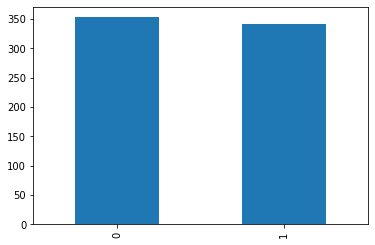

In [44]:
df['category'].value_counts().plot.bar()

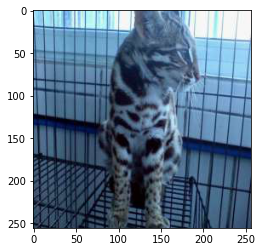

In [45]:
sample = random.choice(filenames)
image = load_img("./dataset256x256/dataset_256x256/train/"+sample)
plt.imshow(image)

In [46]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax')) # 2 because we have cat and dog classes

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 254, 254, 32)      896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 254, 254, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 127, 127, 32)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 125, 125, 64)      18496     
_________________________________________________________________
batch_normalization_2

In [47]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [48]:
earlystop = EarlyStopping(patience=10)


In [49]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [50]:
#callbacks = [earlystop, learning_rate_reduction]
callbacks = [learning_rate_reduction]


In [51]:
df["category"] = df["category"].replace({0: 'cat', 1: 'LeopardCat'}) 

In [52]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

<AxesSubplot:>

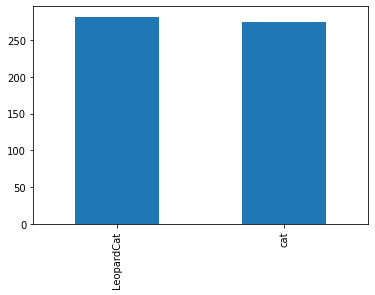

In [53]:
train_df['category'].value_counts().plot.bar()


<AxesSubplot:>

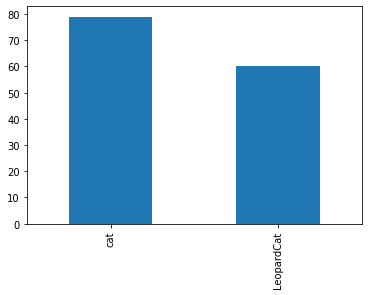

In [54]:
validate_df['category'].value_counts().plot.bar()


In [55]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=15

In [56]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "./dataset256x256/dataset_256x256/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 556 validated image filenames belonging to 2 classes.


In [57]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "./dataset256x256/dataset_256x256/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 139 validated image filenames belonging to 2 classes.


In [58]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    "./dataset256x256/dataset_256x256/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


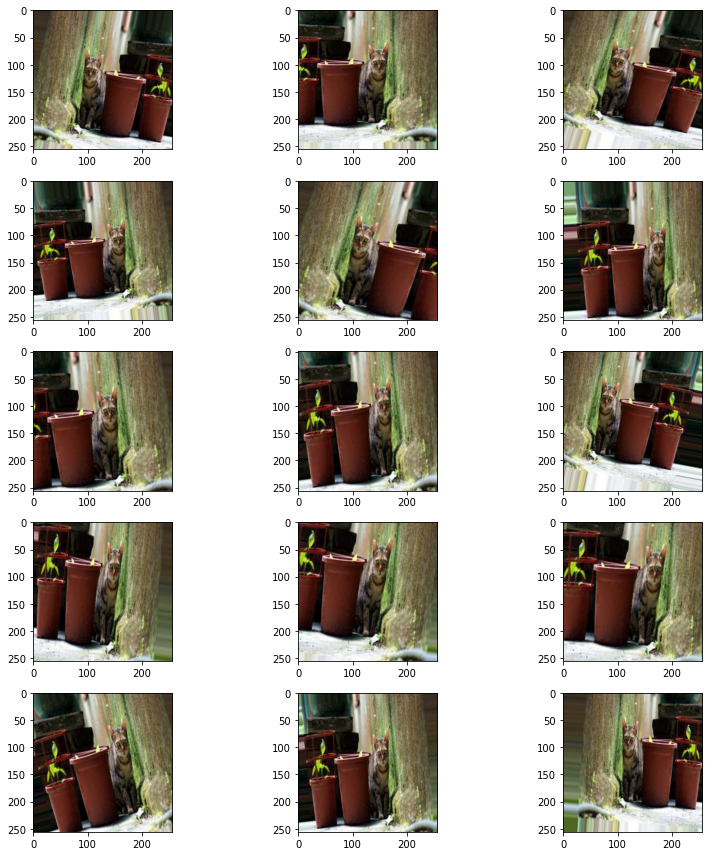

In [59]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

In [269]:
epochs=3 if FAST_RUN else 50
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

Epoch 1/50
37/37 [==============================] - 8s 213ms/step - loss: 0.4114 - acc: 0.8341 - val_loss: 0.6917 - val_acc: 0.6774
Epoch 2/50
37/37 [==============================] - 8s 228ms/step - loss: 0.4668 - acc: 0.7789 - val_loss: 0.6497 - val_acc: 0.6935
Epoch 3/50
37/37 [==============================] - 8s 208ms/step - loss: 0.4230 - acc: 0.8132 - val_loss: 0.5462 - val_acc: 0.7177
Epoch 4/50
37/37 [==============================] - 8s 218ms/step - loss: 0.4284 - acc: 0.7933 - val_loss: 0.6475 - val_acc: 0.7097
Epoch 5/50
37/37 [==============================] - 10s 274ms/step - loss: 0.4823 - acc: 0.7818 - val_loss: 0.7551 - val_acc: 0.6290
Epoch 6/50
37/37 [==============================] - 10s 261ms/step - loss: 0.4263 - acc: 0.8036 - val_loss: 0.5961 - val_acc: 0.7016
Epoch 7/50
37/37 [==============================] - 11s 309ms/step - loss: 0.4452 - acc: 0.8161 - val_loss: 0.6671 - val_acc: 0.6935
Epoch 8/50
37/37 [==============================] - 11s 298ms/step - loss

In [270]:
model.save_weights("model.h5")

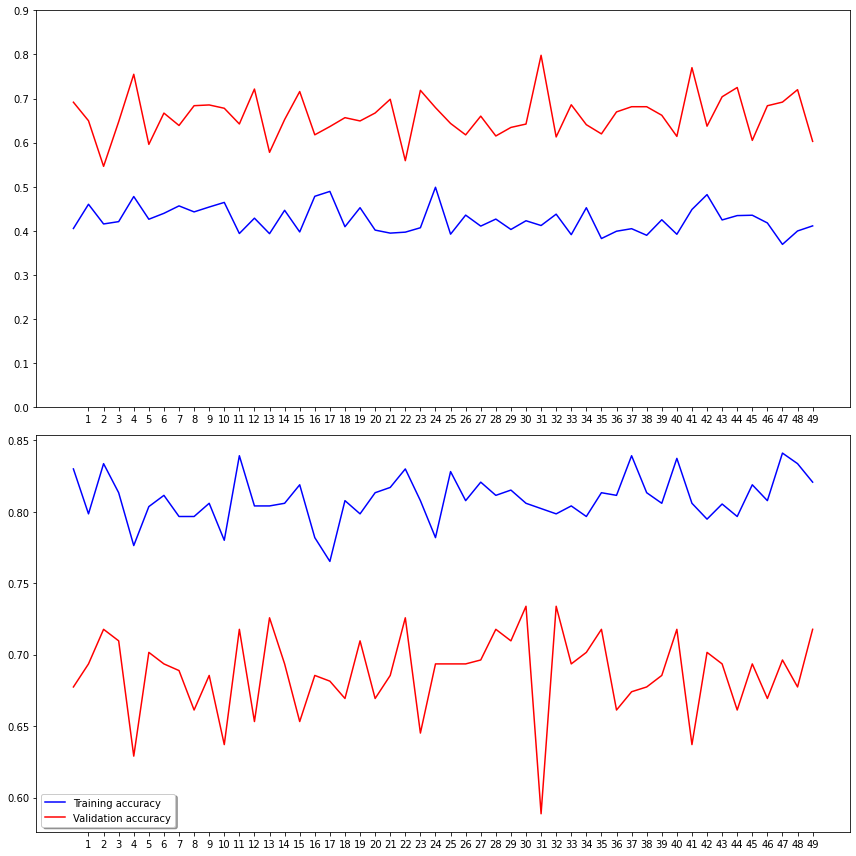

In [271]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['acc'], color='b', label="Training accuracy")
ax2.plot(history.history['val_acc'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

In [259]:
test_filenames = os.listdir("./dataset256x256/dataset_256x256/test/")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

In [260]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "./dataset256x256/dataset_256x256/test/", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

Found 173 validated image filenames.


In [261]:
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))


In [262]:
test_df['category'] = np.argmax(predict, axis=-1)


In [263]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)

In [264]:
test_df['category'] = test_df['category'].replace({ 'LeopardCat': 1, 'cat': 0 })

<AxesSubplot:>

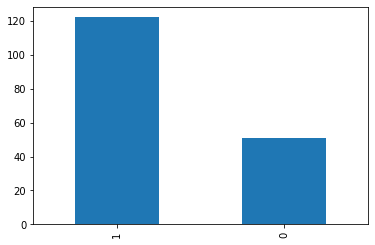

In [265]:
test_df['category'].value_counts().plot.bar()


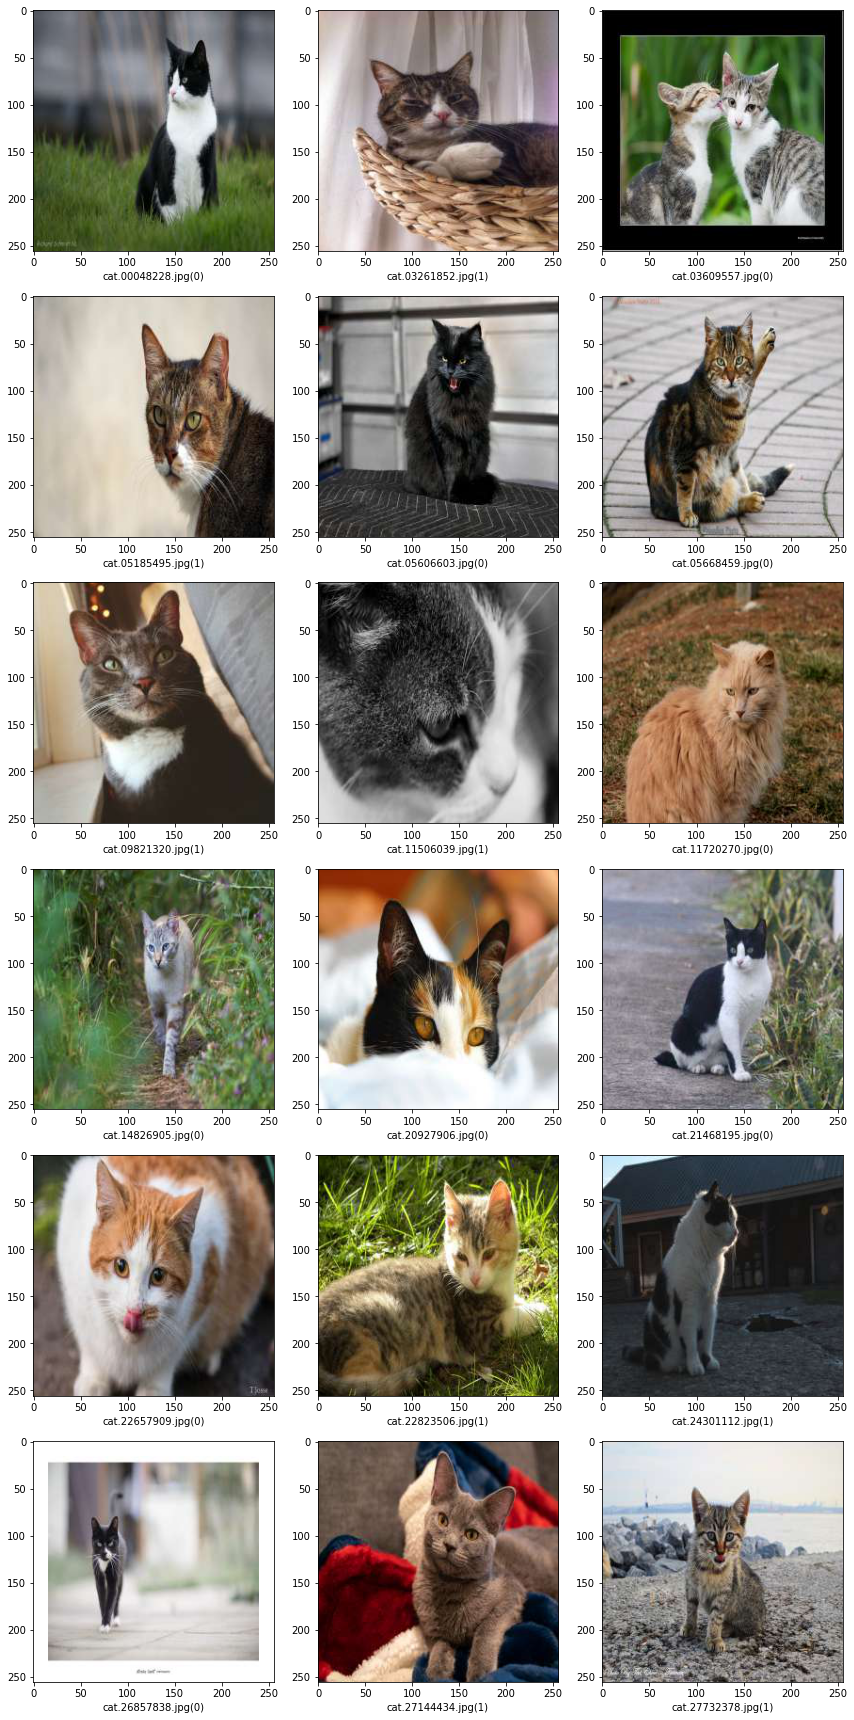

In [266]:
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("./dataset256x256/dataset_256x256/test/"+filename, target_size=IMAGE_SIZE)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()

In [ ]:
submission_df = test_df.copy()
submission_df['id'] = submission_df['filename'].str.split('.').str[0]
submission_df['label'] = submission_df['category']
submission_df.drop(['filename', 'category'], axis=1, inplace=True)
submission_df.to_csv('submission.csv', index=False)

# VGG16

## Reference:　https://www.kaggle.com/bulentsiyah/dogs-vs-cats-classification-vgg16-fine-tuning

In [291]:
import numpy as np
import pandas as pd 
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os
print(os.listdir("./dataset256x256/dataset_256x256/"))

['test', 'train']


In [292]:
FAST_RUN = False
IMAGE_WIDTH=256
IMAGE_HEIGHT=256
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

In [293]:
# cat == 0, LeopardCat ==1

filenames = os.listdir("./dataset256x256/dataset_256x256/train")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'cat':
        categories.append(0)
    else:
        categories.append(1)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [294]:
df.tail()


filename  category
690  LeopardCat.98222484.jpg         1
691  LeopardCat.98225008.jpg         1
692  LeopardCat.98366474.jpg         1
693  LeopardCat.99024079.jpg         1
694  LeopardCat.99867990.jpg         1

<AxesSubplot:>

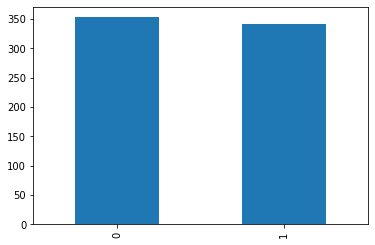

In [295]:
df['category'].value_counts().plot.bar()

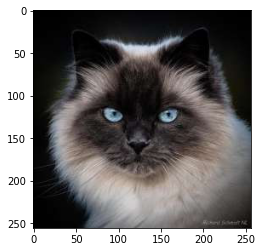

In [296]:
sample = random.choice(filenames)
image = load_img("./dataset256x256/dataset_256x256/train/"+sample)
plt.imshow(image)

In [297]:
from keras.models import Sequential
from keras import layers
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation,GlobalMaxPooling2D
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.applications import VGG16
from keras.models import Model

image_size = 256
input_shape = (image_size, image_size, 3)

epochs = 50
batch_size = 16

pre_trained_model = VGG16(input_shape=input_shape, include_top=False, weights="imagenet")
    
for layer in pre_trained_model.layers[:15]:
    layer.trainable = False

for layer in pre_trained_model.layers[15:]:
    layer.trainable = True
    
last_layer = pre_trained_model.get_layer('block5_pool')
last_output = last_layer.output
    
# Flatten the output layer to 1 dimension
x = GlobalMaxPooling2D()(last_output)
# Add a fully connected layer with 512 hidden units and ReLU activation
x = Dense(512, activation='relu')(x)
# Add a dropout rate of 0.5
x = Dropout(0.5)(x)
# Add a final sigmoid layer for classification
x = layers.Dense(1, activation='sigmoid')(x)

model = Model(pre_trained_model.input, x)

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

model.summary()

58892288/58889256 [==============================] - 14s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        (None, 256, 256, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_poo

In [300]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "./dataset256x256/dataset_256x256/train", 
    x_col='filename',
    y_col='category',
    class_mode='binary',
    target_size=(image_size, image_size),
    batch_size=batch_size
)

Found 556 validated image filenames belonging to 2 classes.


In [301]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "./dataset256x256/dataset_256x256/train", 
    x_col='filename',
    y_col='category',
    class_mode='binary',
    target_size=(image_size, image_size),
    batch_size=batch_size
)

Found 139 validated image filenames belonging to 2 classes.


Found 1 validated image filenames belonging to 1 classes.


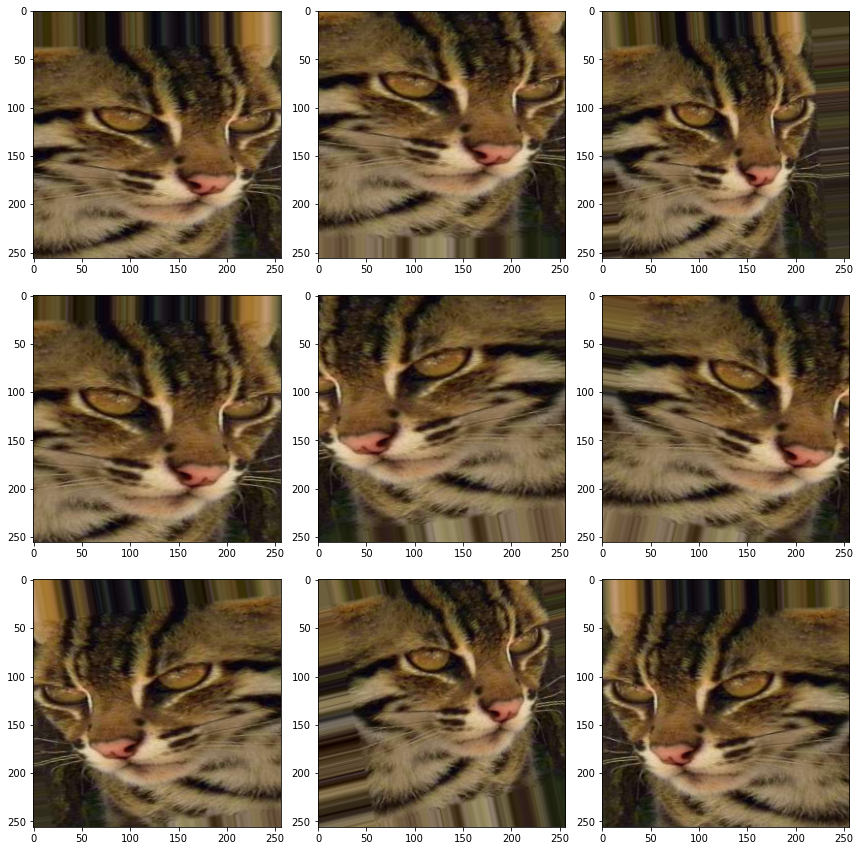

In [304]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    "./dataset256x256/dataset_256x256/train/", 
    x_col='filename',
    y_col='category',
    class_mode='categorical'
)
plt.figure(figsize=(12, 12))
for i in range(0, 9):
    plt.subplot(3, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

In [305]:
history = model.fit_generator(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size)

Epoch 1/50
34/34 [==============================] - 63s 2s/step - loss: 0.7407 - acc: 0.5570 - val_loss: 0.6179 - val_acc: 0.7500
Epoch 2/50
34/34 [==============================] - 9s 258ms/step - loss: 0.6722 - acc: 0.6305 - val_loss: 0.5578 - val_acc: 0.8211
Epoch 3/50
34/34 [==============================] - 10s 293ms/step - loss: 0.5841 - acc: 0.6808 - val_loss: 0.4858 - val_acc: 0.8780
Epoch 4/50
34/34 [==============================] - 11s 315ms/step - loss: 0.5576 - acc: 0.7108 - val_loss: 0.4512 - val_acc: 0.8780
Epoch 5/50
34/34 [==============================] - 11s 334ms/step - loss: 0.5043 - acc: 0.7561 - val_loss: 0.4648 - val_acc: 0.8130
Epoch 6/50
34/34 [==============================] - 12s 366ms/step - loss: 0.4726 - acc: 0.7813 - val_loss: 0.3597 - val_acc: 0.8943
Epoch 7/50
34/34 [==============================] - 12s 364ms/step - loss: 0.4231 - acc: 0.8119 - val_loss: 0.4119 - val_acc: 0.8049
Epoch 8/50
34/34 [==============================] - 12s 351ms/step - loss

In [306]:
loss, accuracy = model.evaluate_generator(validation_generator, total_validate//batch_size, workers=12)
print("Test: accuracy = %f  ;  loss = %f " % (accuracy, loss))

Test: accuracy = 0.959350  ;  loss = 0.149738 


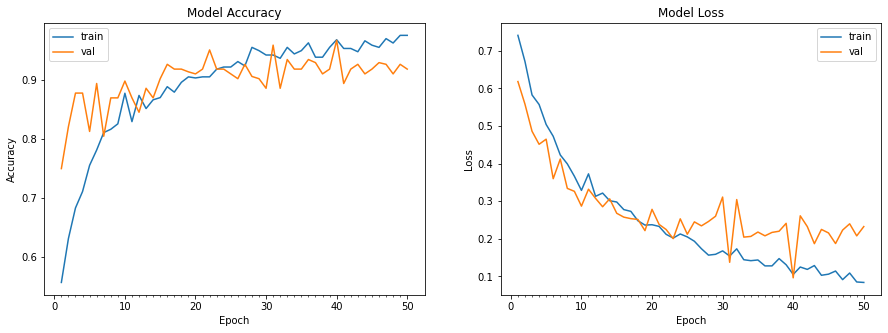

In [307]:
def plot_model_history(model_history, acc='acc', val_acc='val_acc'):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    axs[0].plot(range(1,len(model_history.history[acc])+1),model_history.history[acc])
    axs[0].plot(range(1,len(model_history.history[val_acc])+1),model_history.history[val_acc])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history[acc])+1),len(model_history.history[acc])/10)
    axs[0].legend(['train', 'val'], loc='best')
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()
    
plot_model_history(history)

In [311]:
test_filenames = os.listdir("./dataset256x256/dataset_256x256/test/")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

In [312]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "./dataset256x256/dataset_256x256/test/", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    batch_size=batch_size,
    target_size=(image_size, image_size),
    shuffle=False
)

Found 173 validated image filenames.


In [313]:
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))
threshold = 0.5
test_df['category'] = np.where(predict > threshold, 1,0)

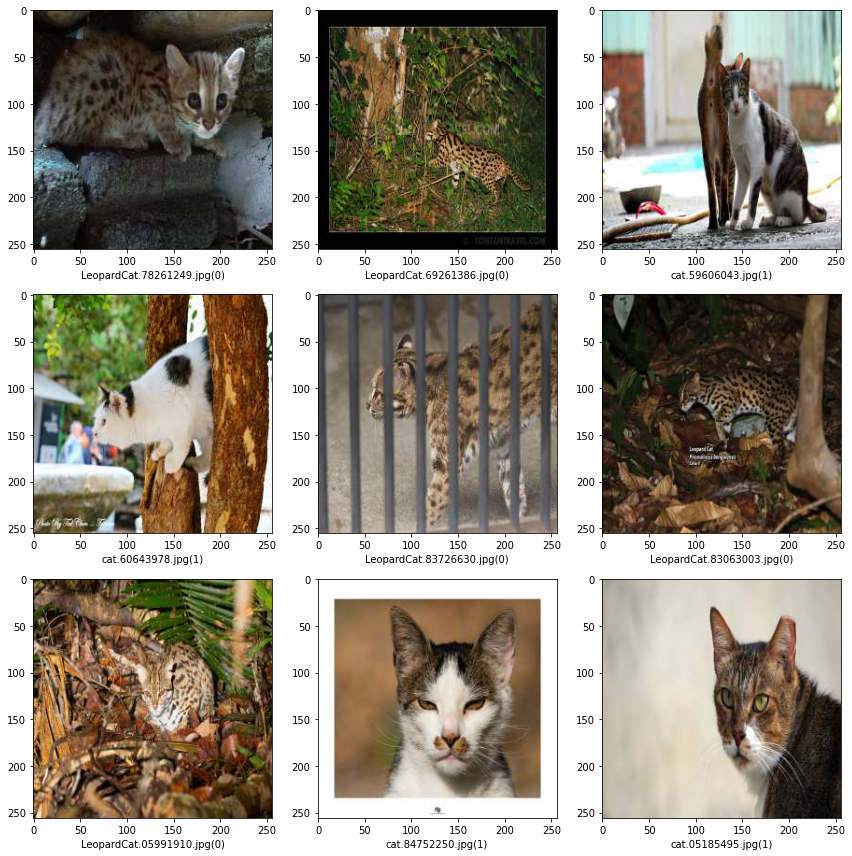

In [315]:
sample_test = test_df.sample(n=9).reset_index()
sample_test.head()
plt.figure(figsize=(12, 12))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("./dataset256x256/dataset_256x256/test/"+filename, target_size=(256, 256))
    plt.subplot(3, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')')
plt.tight_layout()
plt.show()

# InceptionResNetV2

## Reference:　https://keras.io/api/applications/、https://github.com/jkjung-avt/keras-cats-dogs-tutorial

In [60]:
import numpy as np
import pandas as pd 
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os
print(os.listdir("./dataset256x256/dataset_256x256/"))

['test', 'train']


In [61]:
FAST_RUN = False
IMAGE_WIDTH=256
IMAGE_HEIGHT=256
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

In [62]:
# cat == 0, LeopardCat ==1

filenames = os.listdir("./dataset256x256/dataset_256x256/train")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'cat':
        categories.append(0)
    else:
        categories.append(1)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [63]:
df.tail()


filename  category
690  LeopardCat.98222484.jpg         1
691  LeopardCat.98225008.jpg         1
692  LeopardCat.98366474.jpg         1
693  LeopardCat.99024079.jpg         1
694  LeopardCat.99867990.jpg         1

<AxesSubplot:>

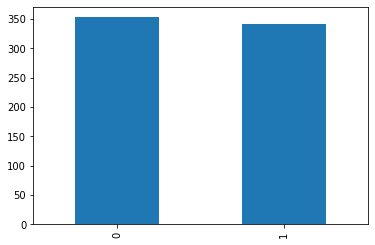

In [33]:
df['category'].value_counts().plot.bar()

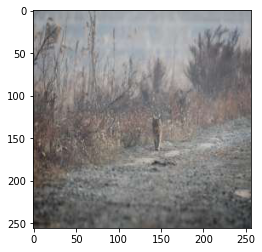

In [64]:
sample = random.choice(filenames)
image = load_img("./dataset256x256/dataset_256x256/train/"+sample)
plt.imshow(image)

In [65]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "./dataset256x256/dataset_256x256/train", 
    x_col='filename',
    y_col='category',
    class_mode='categorical',
    target_size=(256, 256),
    batch_size=batch_size
)

Found 556 validated image filenames belonging to 2 classes.


In [66]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "./dataset256x256/dataset_256x256/train", 
    x_col='filename',
    y_col='category',
    class_mode='binary',
    target_size=(256, 256),
    batch_size=batch_size
)

Found 139 validated image filenames belonging to 2 classes.


Found 1 validated image filenames belonging to 1 classes.


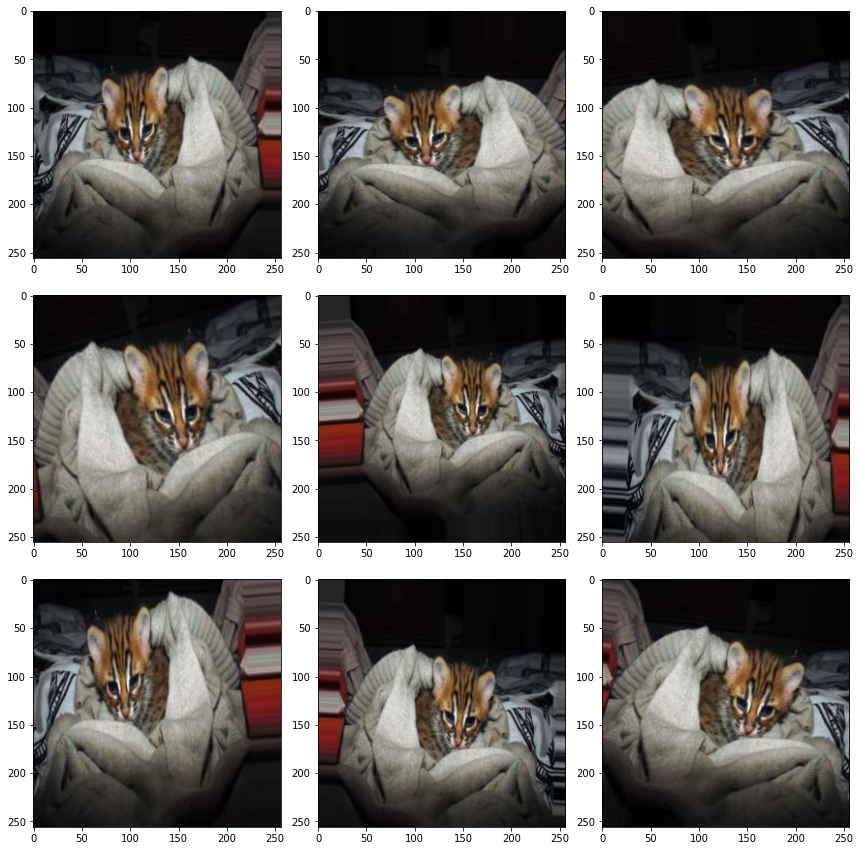

In [67]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    "./dataset256x256/dataset_256x256/train/", 
    x_col='filename',
    y_col='category',
    class_mode='categorical'
)
plt.figure(figsize=(12, 12))
for i in range(0, 9):
    plt.subplot(3, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

In [68]:
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import Flatten, Dense, Dropout
from tensorflow.python.keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
from tensorflow.python.keras.optimizers import Adam
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator


DATASET_PATH  = './dataset256x256/dataset_256x256/'
IMAGE_SIZE    = (256, 256)
NUM_CLASSES   = 2
BATCH_SIZE    = 32  # try reducing batch size or freeze more layers if your GPU runs out of memory
FREEZE_LAYERS = 2  # freeze the first this many layers for training
NUM_EPOCHS    = 50
WEIGHTS_FINAL = 'model-inception_resnet_v2-final.h5'


train_datagen = ImageDataGenerator(rescale=1./255)

train_batches = train_datagen.flow_from_dataframe(
    train_df, 
    "./dataset256x256/dataset_256x256/train", 
    x_col='filename',
    y_col='category',
    class_mode='binary',
    target_size=(256, 256),
    batch_size=batch_size
)


valid_datagen = ImageDataGenerator(rescale=1./255)

valid_batches = validation_datagen.flow_from_dataframe(
    validate_df, 
    "./dataset256x256/dataset_256x256/train", 
    x_col='filename',
    y_col='category',
    class_mode='binary',
    target_size=(256, 256),
    batch_size=batch_size
)

# show class indices
print('****************')
for cls, idx in train_batches.class_indices.items():
    print('Class #{} = {}'.format(idx, cls))
print('****************')

Found 556 validated image filenames belonging to 2 classes.
Found 139 validated image filenames belonging to 2 classes.
****************
Class #0 = LeopardCat
Class #1 = cat
****************


In [70]:
net = InceptionResNetV2(include_top=False,
                        weights='imagenet',
                        input_tensor=None,
                        input_shape=(IMAGE_SIZE[0],IMAGE_SIZE[1],3))
#net.summary()

# conv_7b_ac (Activation)

In [49]:
# import tensorflow as tf
# tf.keras.utils.plot_model(net, to_file='model.png', show_shapes=True)

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.519756 to fit



In [71]:
x = net.output
x = Flatten()(x)
x = Dropout(0.5)(x)
output_layer = Dense(NUM_CLASSES, activation='softmax', name='softmax')(x)
net_final = Model(inputs=net.input, outputs=output_layer)
for layer in net_final.layers[:FREEZE_LAYERS]:
    layer.trainable = False
for layer in net_final.layers[FREEZE_LAYERS:]:
    layer.trainable = True

In [ ]:
net_final.trainable_weights

In [ ]:
net_final.summary()

In [83]:
net_final.compile(optimizer=Adam(lr=1e-4),
                  loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [84]:
# train the model
history = net_final.fit_generator(train_batches,
                        steps_per_epoch = train_batches.samples // BATCH_SIZE,
                        validation_data = valid_batches,
                        validation_steps = valid_batches.samples // BATCH_SIZE,
                        epochs = 50)

# save trained weights
# net_final.save(WEIGHTS_FINAL)

Epoch 1/50
38/38 [==============================] - 67s 2s/step - loss: 0.4723 - acc: 0.7896 - val_loss: 0.2062 - val_acc: 0.9281
Epoch 2/50
38/38 [==============================] - 22s 576ms/step - loss: 0.1444 - acc: 0.9478 - val_loss: 0.3106 - val_acc: 0.9353
Epoch 3/50
38/38 [==============================] - 22s 590ms/step - loss: 0.0528 - acc: 0.9892 - val_loss: 0.2022 - val_acc: 0.9424
Epoch 4/50
38/38 [==============================] - 20s 529ms/step - loss: 0.0442 - acc: 0.9910 - val_loss: 0.2622 - val_acc: 0.9424
Epoch 5/50
38/38 [==============================] - 22s 568ms/step - loss: 0.0134 - acc: 0.9946 - val_loss: 0.2235 - val_acc: 0.9281
Epoch 6/50
38/38 [==============================] - 22s 580ms/step - loss: 0.0239 - acc: 0.9946 - val_loss: 0.1700 - val_acc: 0.9496
Epoch 7/50
38/38 [==============================] - 21s 551ms/step - loss: 0.0216 - acc: 0.9910 - val_loss: 0.6024 - val_acc: 0.8633
Epoch 8/50
38/38 [==============================] - 21s 554ms/step - los

In [85]:
loss, accuracy = net_final.evaluate_generator(validation_generator, total_validate//batch_size, workers=12)
print("Test: accuracy = %f  ;  loss = %f " % (accuracy, loss))

Test: accuracy = 0.949640  ;  loss = 0.481726 


In [1]:
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import Flatten, Dense, Dropout
from tensorflow.python.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.python.keras.optimizers import Adam
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator


DATASET_PATH  = './dataset256x256/dataset_256x256/'
IMAGE_SIZE    = (256, 256)
NUM_CLASSES   = 2
BATCH_SIZE    = 32  # try reducing batch size or freeze more layers if your GPU runs out of memory
FREEZE_LAYERS = 2  # freeze the first this many layers for training
NUM_EPOCHS    = 50
WEIGHTS_FINAL = 'model-resnet50-final.h5'


train_datagen = ImageDataGenerator(rescale=1./255)

train_batches = train_datagen.flow_from_dataframe(
    train_df, 
    "./dataset256x256/dataset_256x256/train", 
    x_col='filename',
    y_col='category',
    class_mode='binary',
    target_size=(256, 256),
    batch_size=batch_size
)


valid_datagen = ImageDataGenerator(rescale=1./255)

valid_batches = validation_datagen.flow_from_dataframe(
    validate_df, 
    "./dataset256x256/dataset_256x256/train", 
    x_col='filename',
    y_col='category',
    class_mode='binary',
    target_size=(256, 256),
    batch_size=batch_size
)

# show class indices
print('****************')
for cls, idx in train_batches.class_indices.items():
    print('Class #{} = {}'.format(idx, cls))
print('****************')

# build our classifier model based on pre-trained ResNet50:
# 1. we don't include the top (fully connected) layers of ResNet50
# 2. we add a DropOut layer followed by a Dense (fully connected)
#    layer which generates softmax class score for each class
# 3. we compile the final model using an Adam optimizer, with a
#    low learning rate (since we are 'fine-tuning')
net = ResNet50(include_top=False, weights='imagenet', input_tensor=None,
               input_shape=(IMAGE_SIZE[0],IMAGE_SIZE[1],3))

net.trainable = False

x = net.output
x = keras.layers.GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
output_layer = Dense(NUM_CLASSES, activation='softmax', name='softmax')(x)
net_final = Model(inputs=net.input, outputs=output_layer)

net_final.compile(optimizer=Adam(lr=1e-4),
                  loss='sparse_categorical_crossentropy', metrics=['accuracy'])
#print(net_final.summary())

/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passing (type, 1) or 

NameError: name 'train_df' is not defined

In [ ]:
# train the model
net_final.fit_generator(train_batches,
                        steps_per_epoch = train_batches.samples // BATCH_SIZE,
                        validation_data = valid_batches,
                        validation_steps = valid_batches.samples // BATCH_SIZE,
                        epochs = NUM_EPOCHS)

In [88]:
loss, accuracy = net_final.evaluate_generator(validation_generator, total_validate//batch_size, workers=12)
print("Test: accuracy = %f  ;  loss = %f " % (accuracy, loss))

Test: accuracy = 0.913669  ;  loss = 0.395371 


In [ ]:
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import Flatten, Dense, Dropout
from tensorflow.python.keras.applications import DenseNet201
from tensorflow.python.keras.optimizers import Adam
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator


DATASET_PATH  = './dataset256x256/dataset_256x256/'
IMAGE_SIZE    = (256, 256)
NUM_CLASSES   = 2
BATCH_SIZE    = 32  # try reducing batch size or freeze more layers if your GPU runs out of memory
FREEZE_LAYERS = 2  # freeze the first this many layers for training
NUM_EPOCHS    = 50
WEIGHTS_FINAL = 'model-DenseNet201-final.h5'


train_datagen = ImageDataGenerator(rescale=1./255)

train_batches = train_datagen.flow_from_dataframe(
    train_df, 
    "./dataset256x256/dataset_256x256/train", 
    x_col='filename',
    y_col='category',
    class_mode='binary',
    target_size=(256, 256),
    batch_size=batch_size
)


valid_datagen = ImageDataGenerator(rescale=1./255)

valid_batches = validation_datagen.flow_from_dataframe(
    validate_df, 
    "./dataset256x256/dataset_256x256/train", 
    x_col='filename',
    y_col='category',
    class_mode='binary',
    target_size=(256, 256),
    batch_size=batch_size
)

# show class indices
print('****************')
for cls, idx in train_batches.class_indices.items():
    print('Class #{} = {}'.format(idx, cls))
print('****************')

# build our classifier model based on pre-trained ResNet50:
# 1. we don't include the top (fully connected) layers of ResNet50
# 2. we add a DropOut layer followed by a Dense (fully connected)
#    layer which generates softmax class score for each class
# 3. we compile the final model using an Adam optimizer, with a
#    low learning rate (since we are 'fine-tuning')
net = DenseNet201(include_top=False, weights='imagenet', input_tensor=None,
               input_shape=(IMAGE_SIZE[0],IMAGE_SIZE[1],3))
x = net.output
x = Flatten()(x)
x = Dropout(0.5)(x)
output_layer = Dense(NUM_CLASSES, activation='softmax', name='softmax')(x)
net_final = Model(inputs=net.input, outputs=output_layer)
for layer in net_final.layers[:FREEZE_LAYERS]:
    layer.trainable = False
for layer in net_final.layers[FREEZE_LAYERS:]:
    layer.trainable = True
net_final.compile(optimizer=Adam(lr=1e-4),
                  loss='sparse_categorical_crossentropy', metrics=['accuracy'])
#print(net_final.summary())

In [79]:
# train the model
history = net_final.fit_generator(train_batches,
                        steps_per_epoch = train_batches.samples // BATCH_SIZE,
                        validation_data = valid_batches,
                        validation_steps = valid_batches.samples // BATCH_SIZE,
                        epochs = NUM_EPOCHS)

Epoch 1/50
38/38 [==============================] - 17s 440ms/step - loss: 0.0044 - acc: 0.9982 - val_loss: 0.1409 - val_acc: 0.9568
Epoch 2/50
38/38 [==============================] - 15s 399ms/step - loss: 0.0052 - acc: 0.9982 - val_loss: 0.1443 - val_acc: 0.9568
Epoch 3/50
38/38 [==============================] - 18s 478ms/step - loss: 0.0087 - acc: 0.9964 - val_loss: 0.1449 - val_acc: 0.9568
Epoch 4/50
38/38 [==============================] - 18s 477ms/step - loss: 0.0028 - acc: 0.9982 - val_loss: 0.1620 - val_acc: 0.9568
Epoch 5/50
38/38 [==============================] - 18s 470ms/step - loss: 0.0026 - acc: 0.9982 - val_loss: 0.1606 - val_acc: 0.9496
Epoch 6/50
38/38 [==============================] - 16s 428ms/step - loss: 0.2863 - acc: 0.9748 - val_loss: 0.6100 - val_acc: 0.8993
Epoch 7/50
38/38 [==============================] - 18s 473ms/step - loss: 0.8818 - acc: 0.9137 - val_loss: 0.7206 - val_acc: 0.9281
Epoch 8/50
38/38 [==============================] - 18s 475ms/step - 

In [77]:
loss, accuracy = net_final.evaluate_generator(validation_generator, total_validate//batch_size, workers=12)
print("Test: accuracy = %f  ;  loss = %f " % (accuracy, loss))

Test: accuracy = 0.964029  ;  loss = 0.147559 


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  from ipykernel import kernelapp as app


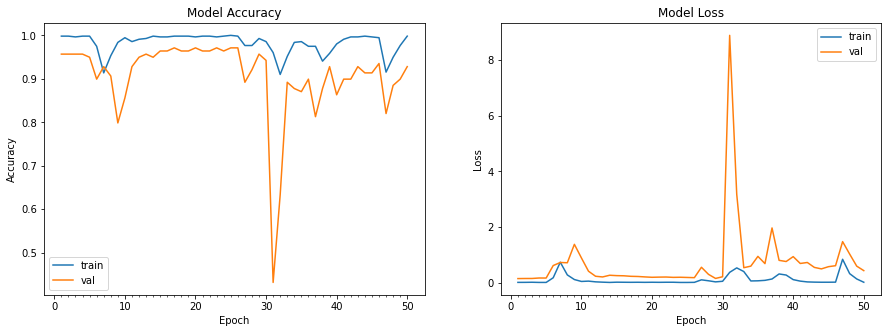

In [82]:
def plot_model_history(model_history, acc='acc', val_acc='val_acc'):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    axs[0].plot(range(1,len(model_history.history[acc])+1),model_history.history[acc])
    axs[0].plot(range(1,len(model_history.history[val_acc])+1),model_history.history[val_acc])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history[acc])+1),len(model_history.history[acc])/10)
    axs[0].legend(['train', 'val'], loc='best')
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()
    
plot_model_history(history)

In [83]:
test_filenames = os.listdir("./dataset256x256/dataset_256x256/test/")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

In [85]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "./dataset256x256/dataset_256x256/test/", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    batch_size=batch_size,
    target_size=(256, 256),
    shuffle=False
)

Found 173 validated image filenames.


In [ ]:
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))
threshold = 0.5
test_df['category'] = np.where(predict > threshold, 1,0)

In [ ]:
sample_test = test_df.sample(n=9).reset_index()
sample_test.head()
plt.figure(figsize=(12, 12))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("./dataset256x256/dataset_256x256/test/"+filename, target_size=(256, 256))
    plt.subplot(3, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')')
plt.tight_layout()
plt.show()

In [89]:
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import Flatten, Dense, Dropout
from tensorflow.python.keras.applications import VGG16
from tensorflow.python.keras.optimizers import Adam
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator


DATASET_PATH  = './dataset256x256/dataset_256x256/'
IMAGE_SIZE    = (256, 256)
NUM_CLASSES   = 2
BATCH_SIZE    = 32  # try reducing batch size or freeze more layers if your GPU runs out of memory
FREEZE_LAYERS = 2  # freeze the first this many layers for training
NUM_EPOCHS    = 50
WEIGHTS_FINAL = 'model-vgg16-final.h5'


train_datagen = ImageDataGenerator(rescale=1./255)

train_batches = train_datagen.flow_from_dataframe(
    train_df, 
    "./dataset256x256/dataset_256x256/train", 
    x_col='filename',
    y_col='category',
    class_mode='binary',
    target_size=(256, 256),
    batch_size=batch_size
)


valid_datagen = ImageDataGenerator(rescale=1./255)

valid_batches = validation_datagen.flow_from_dataframe(
    validate_df, 
    "./dataset256x256/dataset_256x256/train", 
    x_col='filename',
    y_col='category',
    class_mode='binary',
    target_size=(256, 256),
    batch_size=batch_size
)

# show class indices
print('****************')
for cls, idx in train_batches.class_indices.items():
    print('Class #{} = {}'.format(idx, cls))
print('****************')

# build our classifier model based on pre-trained ResNet50:
# 1. we don't include the top (fully connected) layers of ResNet50
# 2. we add a DropOut layer followed by a Dense (fully connected)
#    layer which generates softmax class score for each class
# 3. we compile the final model using an Adam optimizer, with a
#    low learning rate (since we are 'fine-tuning')
net = VGG16(include_top=False, weights='imagenet', input_tensor=None,
               input_shape=(IMAGE_SIZE[0],IMAGE_SIZE[1],3))
x = net.output
x = Flatten()(x)
x = Dropout(0.5)(x)
output_layer = Dense(NUM_CLASSES, activation='softmax', name='softmax')(x)
net_final = Model(inputs=net.input, outputs=output_layer)
for layer in net_final.layers[:FREEZE_LAYERS]:
    layer.trainable = False
for layer in net_final.layers[FREEZE_LAYERS:]:
    layer.trainable = True
net_final.compile(optimizer=Adam(lr=1e-4),
                  loss='binary_crossentropy', metrics=['accuracy'])
#print(net_final.summary())

Found 556 validated image filenames belonging to 2 classes.
Found 139 validated image filenames belonging to 2 classes.
****************
Class #0 = LeopardCat
Class #1 = cat
****************


In [90]:
# train the model
history = net_final.fit_generator(train_batches,
                        steps_per_epoch = train_batches.samples // BATCH_SIZE,
                        validation_data = valid_batches,
                        validation_steps = valid_batches.samples // BATCH_SIZE,
                        epochs = NUM_EPOCHS)

Epoch 1/50
38/38 [==============================] - 14s 380ms/step - loss: 0.7189 - acc: 0.5881 - val_loss: 0.5155 - val_acc: 0.7842
Epoch 2/50
38/38 [==============================] - 6s 162ms/step - loss: 0.5160 - acc: 0.7356 - val_loss: 0.3968 - val_acc: 0.7986
Epoch 3/50
38/38 [==============================] - 9s 229ms/step - loss: 0.6487 - acc: 0.6673 - val_loss: 0.4880 - val_acc: 0.7698
Epoch 4/50
38/38 [==============================] - 9s 225ms/step - loss: 0.4931 - acc: 0.7788 - val_loss: 0.7015 - val_acc: 0.5899
Epoch 5/50
38/38 [==============================] - 5s 141ms/step - loss: 0.7062 - acc: 0.5342 - val_loss: 0.6737 - val_acc: 0.5899
Epoch 6/50
38/38 [==============================] - 5s 144ms/step - loss: 0.6737 - acc: 0.5665 - val_loss: 0.6483 - val_acc: 0.5683
Epoch 7/50
38/38 [==============================] - 6s 145ms/step - loss: 0.4957 - acc: 0.7446 - val_loss: 0.4457 - val_acc: 0.8489
Epoch 8/50
38/38 [==============================] - 5s 145ms/step - loss: 0

In [91]:
loss, accuracy = net_final.evaluate_generator(validation_generator, total_validate//batch_size, workers=12)
print("Test: accuracy = %f  ;  loss = %f " % (accuracy, loss))

Test: accuracy = 0.920863  ;  loss = 0.471898 
